In [76]:
# importamos las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

### 1. Carga de datos:
  * Descarga el dataset «Heart Disease UCI» de Kaggle. Explora las características que están relacionadas con la edad, el sexo, la presión arterial y otras variables clínicas.
  * Verifica si hay valores nulos en el dataset y realiza el preprocesamiento necesario, como la imputación de valores faltantes y la normalización de las variables numéricas.

In [43]:
# cargamos el dataset
ruta='../data/heart_disease_uci.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(920, 16)

In [44]:
df.head() # exploramos las primeras filas

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [45]:
print(df.columns) # mostramos las columnas del df

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


Diccionario de datos:
* id: Es un identificador único para cada registro en el conjunto de datos. Cada número representa a un paciente específico.
* age: Edad del paciente en años.
* sex: Género del paciente (por ejemplo, "Male" para hombre, "Female" para mujer).
* dataset: El nombre del conjunto de datos, que en este caso es "Cleveland". Esto puede hacer referencia a que estos datos provienen del hospital o estudio específico de Cleveland.
    * cp (Chest Pain Type): Tipo de dolor en el pecho que experimenta el paciente. Los valores posibles son:
    * "typical angina": Angina típica.
    * "atypical angina": Angina atípica.
    * "non-anginal": Dolor no relacionado con angina.
    * "asymptomatic": Sin síntomas.
* trestbps (Resting Blood Pressure): Presión arterial del paciente en reposo, medida en milímetros de mercurio (mmHg).
* chol (Serum Cholestoral): Nivel de colesterol en suero del paciente, medido en miligramos por decilitro (mg/dl).
* fbs (Fasting Blood Sugar): Nivel de azúcar en sangre en ayunas.
    * "TRUE": El paciente tiene niveles elevados de azúcar en sangre.
    * "FALSE": El paciente tiene niveles normales de azúcar en sangre.
* restecg (Resting Electrocardiographic Results): Resultados del electrocardiograma en reposo del paciente. Los valores típicos pueden ser:
    * "normal": Electrocardiograma normal.
    * "lv hypertrophy": Hipertrofia ventricular izquierda.
* thalch (Maximum Heart Rate Achieved): La frecuencia cardíaca máxima alcanzada por el paciente durante la prueba de esfuerzo.
* exang (Exercise Induced Angina): Indicación de si el paciente experimentó angina durante el ejercicio.
    * "TRUE": El paciente experimentó angina inducida por ejercicio.
    * "FALSE": No se experimentó angina.
* oldpeak: Depresión del ST (un indicador que se observa en el electrocardiograma), medida en relación con el descanso.
* slope (Slope of Peak Exercise ST Segment): Pendiente del segmento ST durante el ejercicio, que indica la gravedad de la angina. Puede tener los siguientes valores:
    * "upsloping": Ascendente.
    * "flat": Plano.
    * "downsloping": Descendente.
* ca (Number of Major Vessels Colored by Flourosopy): Número de arterias principales que se muestran bloqueadas en la fluoroscopia (prueba de imágenes médicas). Los valores pueden ser entre 0 y 3.
* thal: Tipo de talasemia (una condición de la sangre). Los valores posibles pueden ser:
    * "normal": Normal.
    * "reversable defect": Defecto reversible.
    * "fixed defect": Defecto fijo.
* num: Este es el valor objetivo que indica si el paciente tiene una enfermedad cardíaca. Es la etiqueta de salida (variable dependiente). Los valores son:
    * "0": Sin enfermedad cardíaca.
    * "1", "2", "3": Indica diferentes grados de enfermedad cardíaca (de leve a grave).

In [46]:
df.isnull().sum() # verificamos la existencia de valores nulos

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [47]:
df['ca'].unique()

array([ 0.,  3.,  2.,  1., nan])

In [48]:
df['slope'].unique()

array(['downsloping', 'flat', 'upsloping', nan], dtype=object)

In [49]:
df['restecg'].unique()


array(['lv hypertrophy', 'normal', 'st-t abnormality', nan], dtype=object)

In [50]:
df['thal'].unique()

array(['fixed defect', 'normal', 'reversable defect', nan], dtype=object)

In [51]:
df['slope'] = df['slope'].fillna('flat')
df['thal'] = df['thal'].fillna('normal')
df['restecg'] = df['restecg'].fillna('normal')
df['ca'] = df['ca'].fillna('0')

In [52]:
df.duplicated().sum() # verificamos si existen valores nulos

0

In [53]:
# Asumimos que 'slope', 'restecg', 'thal' son columnas con valores no numéricos
label_cols = ['slope', 'restecg', 'thal']

# Creamos un objeto LabelEncoder
encoder = LabelEncoder()

# Aplicamos el LabelEncoder en cada columna categórica
for col in label_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))  # Convertir a cadena si hay NaNs

# Verificamos los resultados
print(df[label_cols].head())

   slope  restecg  thal
0      0        0     0
1      1        0     1
2      1        0     2
3      0        1     1
4      2        0     1


In [54]:
# Imputar valores nulos en columnas categóricas con la moda
for col in label_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verificamos los resultados
print(df[label_cols].head())

   slope  restecg  thal
0      0        0     0
1      1        0     1
2      1        0     2
3      0        1     1
4      2        0     1


/tmp/ipykernel_40255/2485036652.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipykernel_40255/2485036652.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

### 2. Exploración y preprocesamiento de datos:
  * Realiza una división del dataset en conjunto de entrenamiento y prueba. Asegúrate de que el dataset esté bien balanceado, verificando la distribución de la variable objetivo (enfermedad cardíaca sí/no).

In [55]:
# Verificamos si hay valores nulos en el DataFrame
print(df.isnull().sum())
# Verificamos si hay registros duplicados
duplicates = df.duplicated().sum()
print(f'Número de registros duplicados: {duplicates}')

# Eliminamos los registros duplicados si existen
df.drop_duplicates(inplace=True)

id           0
age          0
sex          0
dataset      0
cp           0
trestbps    59
chol        30
fbs         90
restecg      0
thalch      55
exang       55
oldpeak     62
slope        0
ca           0
thal         0
num          0
dtype: int64
Número de registros duplicados: 0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   920 non-null    int64  
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     920 non-null    int64  
 13  ca        920 non-null    object 
 14  thal      920 non-null    int64  
 15  num       920 non-null    int64  
dtypes: float64(4), int64(6), object(6)
memory usage: 115.1+ KB


In [57]:
imputer = SimpleImputer(strategy='mean')
df[['trestbps', 'chol', 'thalch', 'oldpeak']] = imputer.fit_transform(df[['trestbps', 'chol', 'thalch', 'oldpeak']])

In [58]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,0,150.0,False,2.3,0,0.0,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,0,108.0,True,1.5,1,3.0,1,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,0,129.0,True,2.6,1,2.0,2,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,1,187.0,False,3.5,0,0.0,1,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,0,172.0,False,1.4,2,0.0,1,0


In [59]:
df = df.dropna(subset=['trestbps', 'chol', 'thalch'])
df.shape

(920, 16)

In [60]:
df = pd.get_dummies(df, columns=['cp', 'dataset', 'fbs', 'exang'], drop_first=True)

In [61]:
# Seleccionamos solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])
df_numeric = df_numeric.drop(columns=['id'])
# Usamos el método IQR para identificar outliers
# Calculamos los cuartiles Q1 y Q3
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Filtramos los outliers
mask = ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
df_filtered = df[mask]


In [62]:

# Seleccionamos las características relevantes para el análisis (excluyendo la columna 'id' y 'dataset')
features = df_filtered.select_dtypes(include=['number']).columns

# Estandarizamos las características seleccionadas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[features])

In [63]:
# Dividimos el dataset en conjuntos de entrenamiento y prueba (80% entrenamiento y 20% prueba)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

### 3. Implementación de la MLP con Dropout:
  * Implementa una red MLP con dos capas ocultas utilizando Keras o cualquier biblioteca de deep learning.
  * Agrega capas de dropout después de cada capa oculta para reducir el riesgo de sobreajuste. Utiliza una tasa de dropout del 20-30%.
  * Implementa el early stopping para detener el entrenamiento cuando la precisión en el conjunto de validación deje de mejorar después de varias épocas (por ejemplo, paciencia de 5 épocas).

In [64]:
df.columns

Index(['id', 'age', 'sex', 'trestbps', 'chol', 'restecg', 'thalch', 'oldpeak',
       'slope', 'ca', 'thal', 'num', 'cp_atypical angina', 'cp_non-anginal',
       'cp_typical angina', 'dataset_Hungary', 'dataset_Switzerland',
       'dataset_VA Long Beach', 'fbs_True', 'exang_True'],
      dtype='object')

In [65]:
df_filtered.head()

,id,age,sex,trestbps,chol,restecg,thalch,oldpeak,slope,ca,thal,num,cp_atypical angina,cp_non-anginal,cp_typical angina,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,fbs_True,exang_True
25,26,50,Female,120.0,219.0,1,158.0,1.6,1,0.0,1,0,False,True,False,False,False,False,False,False
39,40,61,Male,150.0,243.0,1,137.0,1.0,1,0.0,1,0,False,True,False,False,False,False,True,True
69,70,46,Male,150.0,231.0,1,147.0,3.6,1,0.0,1,1,False,True,False,False,False,False,False,False
93,94,44,Female,108.0,141.0,1,175.0,0.6,1,0.0,1,0,False,True,False,False,False,False,False,False
122,123,51,Male,100.0,222.0,1,143.0,1.2,1,0.0,1,0,False,True,False,False,False,False,False,True


In [66]:
X = df_filtered.drop(columns=['id', 'num', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'fbs_True', 'exang_True'])  # Excluimos columnas no relevantes
y = df_filtered['num']  # 'num' es la etiqueta (presencia de enfermedad, 0 o 1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Si es necesario, puedes estandarizar las características (aunque ya lo hicimos previamente)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Crear el modelo MLP
model = Sequential()

# Capa de entrada
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Capa oculta 1 con Dropout
model.add(Dropout(0.25))  # Tasa de dropout del 25%
model.add(Dense(units=32, activation='relu'))

# Capa oculta 2 con Dropout
model.add(Dropout(0.25))  # Tasa de dropout del 25%
model.add(Dense(units=16, activation='relu'))

# Capa de salida (ajusta el número de unidades y la activación según el tipo de problema)
model.add(Dense(units=1, activation='sigmoid'))  # Para clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Se monitorea la pérdida en validación
                               patience=5,  # Si no mejora después de 5 épocas, detener el entrenamiento
                               verbose=1,   # Mostrar los mensajes de parada
                               restore_best_weights=True)  # Restaurar los mejores pesos

# Entrenamiento del modelo
history = model.fit(X_train, y_train,
                    epochs=100,  # Puedes ajustar el número de épocas según sea necesario
                    batch_size=32,  # Tamaño del lote (ajustable)
                    validation_data=(X_test, y_test),  # Validación durante el entrenamiento
                    callbacks=[early_stopping],  # Pasar el callback de early stopping
                    verbose=1)  # Para ver el progreso durante el entrenamiento


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5774 - loss: 0.8117 - val_accuracy: 0.5769 - val_loss: 0.6330
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6196 - loss: 0.6615 - val_accuracy: 0.6538 - val_loss: 0.5843
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5846 - loss: 0.6422 - val_accuracy: 0.7692 - val_loss: 0.5427
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7284 - loss: 0.4829 - val_accuracy: 0.7885 - val_loss: 0.5020
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7629 - loss: 0.4029 - val_accuracy: 0.8269 - val_loss: 0.4595
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7855 - loss: 0.3249 - val_accuracy: 0.8077 - val_loss: 0.4149
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8068 - loss: 0.2157 - val_accuracy: 0.8269 - val_loss: 0.3680
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8460 - loss: 0.1404 - val_accuracy: 0.8269 - val_loss: 0.3

In [69]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8454 - loss: -816.2000
Pérdida en el conjunto de prueba: -678.8102
Precisión en el conjunto de prueba: 0.8462


### 4. Entrenamiento del modelo:
  * Entrena el modelo con early stopping activado, utilizando el optimizador Adam y la función de pérdida binaria (binary_crossentropy). Entrena durante un máximo de 100 épocas.
  * Visualiza las curvas de aprendizaje para observar cómo evoluciona la pérdida y la precisión a lo largo del entrenamiento, especialmente con early stopping activado.

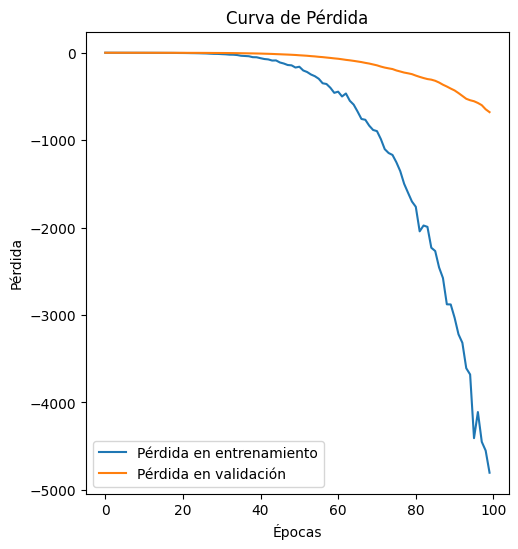

In [70]:
# Visualizar las curvas de aprendizaje
plt.figure(figsize=(12, 6))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

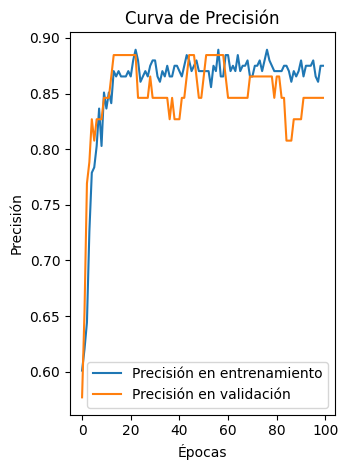

In [71]:
# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

### 5. Evaluación del modelo:
  * Evalúa el modelo en el conjunto de prueba y compara las métricas de rendimiento, como precisión, recall, F1-score y matriz de confusión.
  * Discute cómo el uso de dropout y early stopping ha afectado el rendimiento en comparación con un MLP básico sin estas técnicas.

In [79]:
# Realizar predicciones en el conjunto de prueba 
y_pred = model.predict(X_test)
# Calcular las métricas de evaluación 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
mae = mean_absolute_error(y_test, y_pred) 
# Imprimir las métricas de evaluación 
print(f"RMSE: {rmse:.2f}") 
print(f"MAE: {mae:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE: 0.46
MAE: 0.17


* el modelo tiene un rendimiento bastante bueno, con errores relativamente pequeños en promedio
* el modelo es bastante preciso en general, pero se podría mejorar aún más si se minimizan los errores grandes en algunas predicciones.